## Unsupervisd Learning on Seismic Signals

-- Author: Sayan K. Swar

#### Importing necessary libraries and package installation.

In [ ]:
!pip install obspy

In [1]:
import glob,os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import obspy

#### As there are around 100 files, using Glob to load all the data files into a dataframe.

In [2]:
files = glob.glob("/content/drive/MyDrive/Colab Notebooks/DataSource/NE68_Event_Data/*.csv")

main_dataframe = pd.DataFrame(pd.read_csv(files[0],header=None, names=['radial','transverse','vertical']).assign(FileName=os.path.basename(files[0]).split('.')[0]))

for i in range(1,len(files)):
    data = pd.read_csv(files[i],header=None, names=['radial','transverse','vertical']).assign(FileName=os.path.basename(files[i]).split('.')[0])
    df = pd.DataFrame(data)
    main_dataframe = pd.concat([main_dataframe,df],axis=0)


main_dataframe.head()


,radial,transverse,vertical,FileName
0,207.055557,-278.253357,29.434858,RTZSeis_NE68_Ev001
1,-57.408714,-617.622681,-120.564400,RTZSeis_NE68_Ev001
2,182.529541,-626.170166,-344.563660,RTZSeis_NE68_Ev001
3,590.728516,-269.651459,-220.562927,RTZSeis_NE68_Ev001
4,803.664978,-34.609310,18.437820,RTZSeis_NE68_Ev001


#### Visualizing a signal at random on time domain. The red mark indicate the 120th second from which an earthquake is supposed to be encountered.

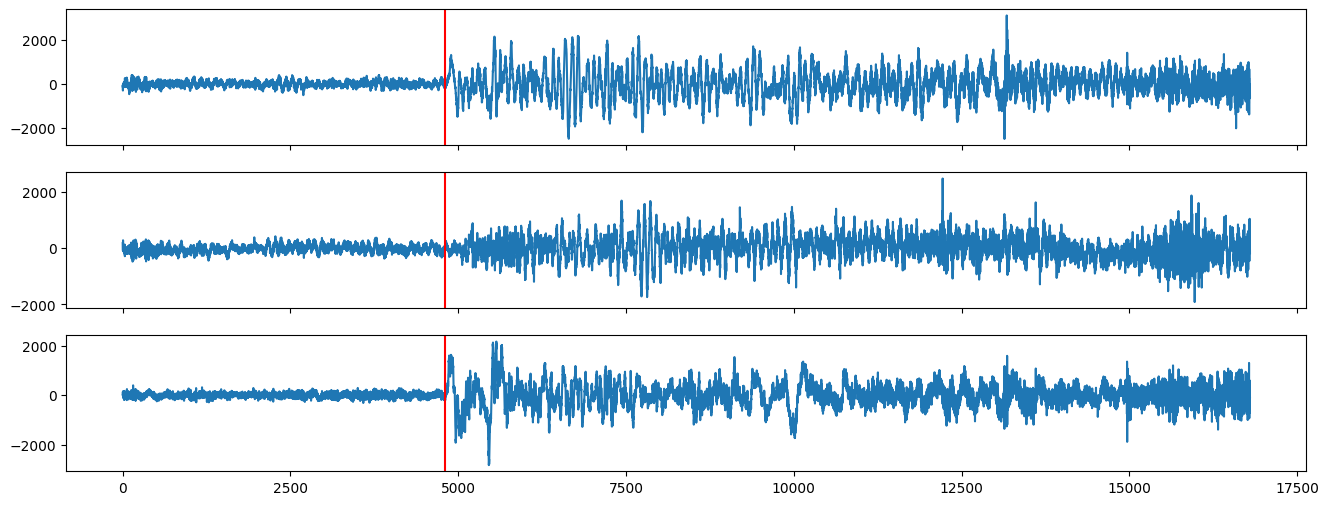

In [3]:
import matplotlib.pyplot as plt

f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16,6))

ax1.plot(main_dataframe.query("FileName=='RTZSeis_NE68_Ev099'")['radial'])
ax1.axvline(x=4801,color='r')

ax2.plot(main_dataframe.query("FileName=='RTZSeis_NE68_Ev099'")['transverse'])
ax2.axvline(x=4801,color='r')

ax3.plot(main_dataframe.query("FileName=='RTZSeis_NE68_Ev099'")['vertical'])
ax3.axvline(x=4801,color='r')


#### Trying to observe the data points of a single signal all three channels in 3D and see how it looks. Although there is no significant pattern that is visible to naked eye.


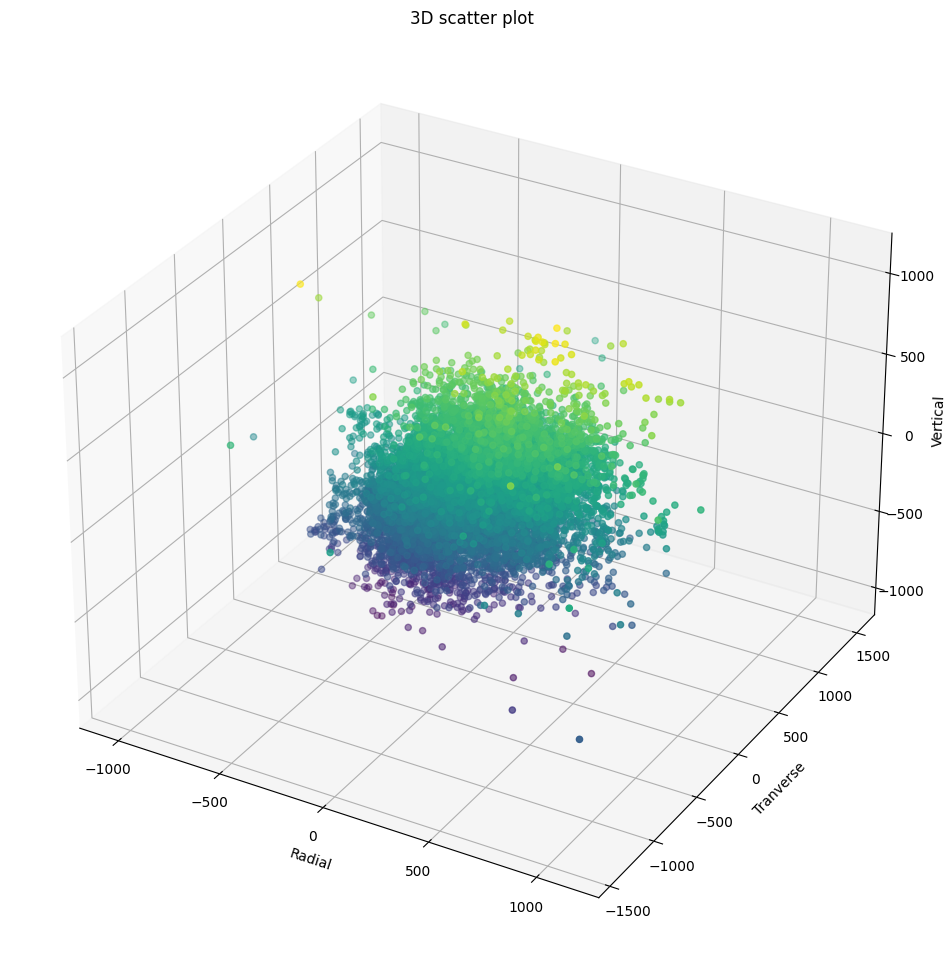

In [4]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')

#colored by the z values
ax.scatter(main_dataframe.query("FileName=='RTZSeis_NE68_Ev023'")['radial'], \
           main_dataframe.query("FileName=='RTZSeis_NE68_Ev023'")['transverse'],\
           main_dataframe.query("FileName=='RTZSeis_NE68_Ev023'")['vertical'], c=main_dataframe.query("FileName=='RTZSeis_NE68_Ev023'")['vertical'])

ax.set_xlabel('Radial')
ax.set_ylabel('Tranverse')
ax.set_zlabel('Vertical')

plt.title('3D scatter plot')
plt.show()

#### Some Notes/findings while research. There are more notes which I have while working, some are noted here and some are not.

In [5]:
#Some Notes:-
#In our case all the signals has been told to arrive at 120 seconds OR at 48001th sample (as frequence is 40hz)

#Note, I think we can not use cross correlation over here for analysis becuase all signals are of the same station and not different.
#Cross correlation is used to understand the time lag between two signals and then identify the source location, distance betwen two stations.
#Although, cross correlation can be used for signals coming in single station as well which are known as seismic event detection/picking.
#In this case a waveform recorded at a station is compared with reference signal which can be a synthetic signal or a waveform of a nearby station.
#Again time delay is used to determine the arrival time os the signal.

#But autocoorelation can be used for analysis. We can try finding if there is a correlation the singal has wit itself which can help us identify some repetative
#patterns in the signal. My idea is to check if the signal during the first 120th second correate with the remaiing part of the singal.
#This may indicate the whole signal is noise. Need to research more on this.

#### **Taking only the vertical component** of the signal for analysis. Vertical component is the one where both body waves (P,S) and surface waves are visible.
#### Although to understand all the aspects of a earthquake source, source to station distance, and effect, analysis of all three components together will yield the best results. But for now, we are focusing on vertial component to analyze how the signal looks like.

In [6]:
main_dataframe_vertical = main_dataframe[["FileName","vertical"]].copy()

list_of_signals = main_dataframe["FileName"].unique()

main_dataframe_vertical.head()

,FileName,vertical
0,RTZSeis_NE68_Ev001,29.434858
1,RTZSeis_NE68_Ev001,-120.564400
2,RTZSeis_NE68_Ev001,-344.563660
3,RTZSeis_NE68_Ev001,-220.562927
4,RTZSeis_NE68_Ev001,18.437820


#### Detect top 5 Peak Code/function. This function is called in the next steps of the code.

##### Refering to taspinar/siml machine learning with signal processing work

In [7]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.
    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.
    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`

    The function can handle NaN's
    See this IPython Notebook [1]_.
    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb
    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)
    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)
    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)
    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)
    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks


def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return [peaks_x, peaks_y] #peaks_x #peaks_x #+ peaks_y

#### Perforing FFT !!! Deriving the frequencies and related amplitude.

##### since our sample rate is 40Hz therefore we will get frequency spectrum upto 20Hz as per Nyquest Frequency Theorem.
#####FFT return complex values where real part is amplitude and imaginary part is frequency.
#####Here we are not interested in the phase of the signal. We are only taking the amplitude, thus we are using abs.



In [8]:
from scipy.fftpack import fft

npts = 16800                                        # number of samples in the trace
dt = 0.025                                          # sample interval

def get_fft_values(y_values, T, N):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)  #calculating based on Nyquest Frequecny
    fft_values_ = fft(np.array(y_values))
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

list_fft_eq = list()
list_fft_eq_labels = list()

list_fft_noise = list()
list_fft_noise_labels = list()

list_fft_all = list()

percentile=5
denominator = 10

for filename in list_of_signals:

  list_fft_eq_labels.append(filename)
  list_fft_noise_labels.append(filename)

  arr_signal = main_dataframe_vertical[main_dataframe_vertical["FileName"]==filename]["vertical"]

  arr_signal_eq = arr_signal[4800:16800]
  arr_signal_noise = arr_signal[0:4800]

  signal_min_eq = np.nanpercentile(arr_signal_eq, percentile)
  signal_max_eq = np.nanpercentile(arr_signal_eq, 100-percentile)
  mph_eq = signal_min_eq + (signal_max_eq - signal_min_eq)/denominator

  signal_min_noise = np.nanpercentile(arr_signal_noise, percentile)
  signal_max_noise = np.nanpercentile(arr_signal_noise, 100-percentile)
  mph_noise = signal_min_noise + (signal_max_noise - signal_min_noise)/denominator

  #f_values, fft_values = get_fft_values(arr_signal,dt,npts)
  #list_fft.append([filename,f_values,fft_values])

  gf_eq_fft = get_features(*get_fft_values(arr_signal_eq, dt, 12000), mph_eq)
  gf_noise_fft = get_features(*get_fft_values(arr_signal_noise, dt, 4800), mph_noise)

  list_fft_eq.append(gf_eq_fft)
  list_fft_noise.append(gf_noise_fft)

  list_flatten = list(itertools.chain.from_iterable(gf_eq_fft))+list(itertools.chain.from_iterable(gf_noise_fft))
  list_fft_all.append([filename]+list_flatten)


In [9]:
df_fft = \
pd.DataFrame(list_fft_all, columns=["filename","fft_eq_freq_peak_1","fft_eq_freq_peak_2","fft_eq_freq_peak_3","fft_eq_freq_peak_4","fft_eq_freq_peak_5",
"fft_eq_amp_peak_1","fft_eq_amp_peak_2","fft_eq_amp_peak_3","fft_eq_amp_peak_4","fft_eq_amp_peak_5",
"fft_noise_freq_peak_1","fft_noise_freq_peak_2","fft_noise_freq_peak_3","fft_noise_freq_peak_4","fft_noise_freq_peak_5",
"fft_noise_amp_peak_1","fft_noise_amp_peak_2","fft_noise_amp_peak_3","fft_noise_amp_peak_4","fft_noise_amp_peak_5"] )

df_fft.head()

,filename,fft_eq_freq_peak_1,fft_eq_freq_peak_2,fft_eq_freq_peak_3,fft_eq_freq_peak_4,fft_eq_freq_peak_5,fft_eq_amp_peak_1,fft_eq_amp_peak_2,fft_eq_amp_peak_3,fft_eq_amp_peak_4,...,fft_noise_freq_peak_1,fft_noise_freq_peak_2,fft_noise_freq_peak_3,fft_noise_freq_peak_4,fft_noise_freq_peak_5,fft_noise_amp_peak_1,fft_noise_amp_peak_2,fft_noise_amp_peak_3,fft_noise_amp_peak_4,fft_noise_amp_peak_5
0,RTZSeis_NE68_Ev001,0.003334,0.013336,0.026671,0.033339,0.050008,4.401341,12.481596,30.855069,70.456164,...,0.016674,0.050021,0.100042,0.150063,0.200083,40.607057,23.098512,28.670232,12.040723,65.102370
1,RTZSeis_NE68_Ev004,0.003334,0.013336,0.026671,0.040007,0.046674,8.758614,15.240614,13.066826,9.226154,...,0.008337,0.025010,0.041684,0.083368,0.100042,28.699555,22.743088,6.581017,1.059510,2.036677
2,RTZSeis_NE68_Ev002,0.003334,0.010002,0.020003,0.026671,0.033339,25.898024,58.175121,77.080755,76.841749,...,0.008337,0.041684,0.075031,0.100042,0.116715,55.866337,44.184091,99.423792,45.179853,73.945282
3,RTZSeis_NE68_Ev003,0.003334,0.013336,0.023337,0.030005,0.036673,211.433854,564.959712,817.466019,831.666906,...,0.058358,0.075031,0.091705,0.116715,0.141726,6250.314946,1029.916270,381.327327,238.130613,168.110919
4,RTZSeis_NE68_Ev006,0.003334,0.010002,0.016669,0.026671,0.036673,17.821656,21.037807,29.579504,23.586126,...,0.016674,0.033347,0.058358,0.083368,0.100042,43.043648,41.245889,41.877773,44.130911,43.343916


#### After perfoming FFT on the signal, showing the frequency distribution of noise data (first 120th seconds) and frequency of normal earth quake data (rest of the signal). The frequency distribution is show in the boxplot.

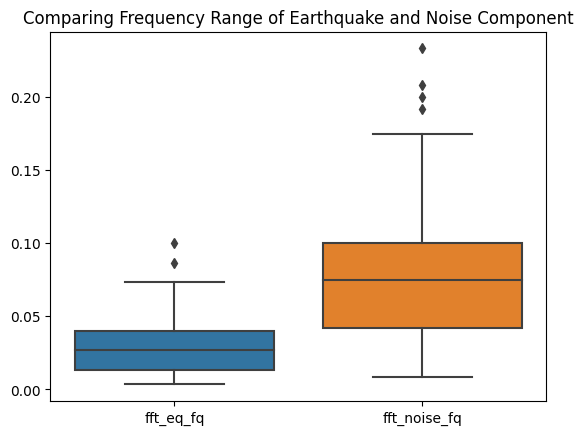

In [10]:
temp=list()
for i in range(len(list_fft_eq)):
  temp.append(list_fft_eq[i][0])

fft_eq_fq_flatten = list(itertools.chain.from_iterable(temp))


temp=list()
for i in range(len(list_fft_noise)):
  temp.append(list_fft_noise[i][0])

fft_noise_fq_flatten = list(itertools.chain.from_iterable(temp))

df_fft_temp = pd.DataFrame(list(zip(fft_eq_fq_flatten,fft_noise_fq_flatten))
                         ,columns=["fft_eq_fq","fft_noise_fq"])


sns.boxplot(data=df_fft_temp)
plt.title('Comparing Frequency Range of Earthquake and Noise Component')
plt.show()

#### Visualize the frequnecy distribution of each peak for noise and earthquake component.

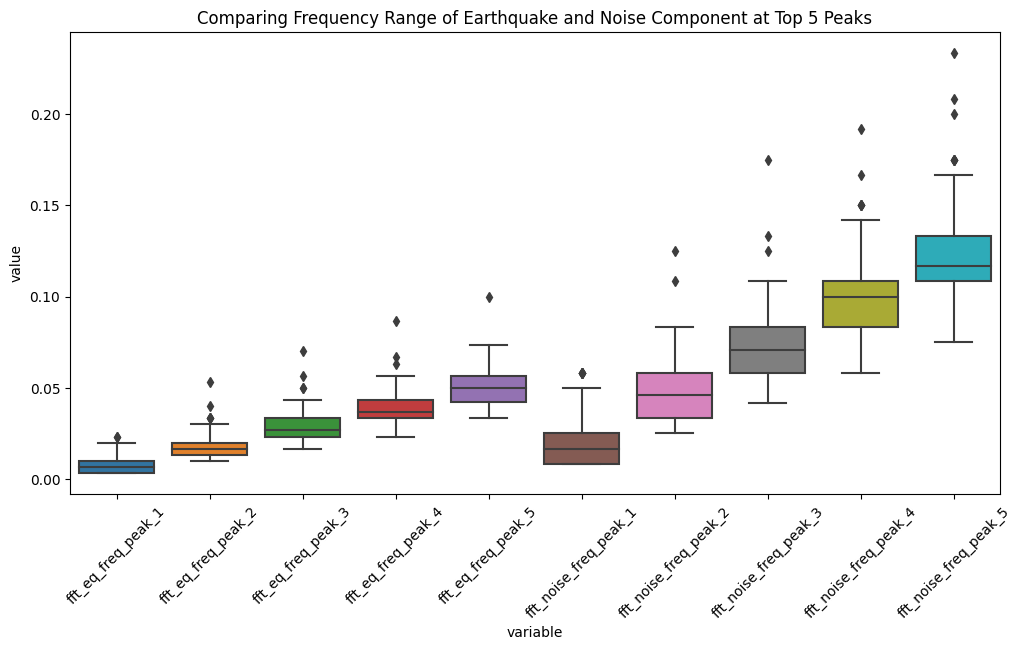

In [11]:
#plot of fft noise vs eq frequency
plt.figure(figsize=(12,6))
sns.boxplot(x="variable", y="value",
            data=pd.melt(df_fft[["fft_eq_freq_peak_1","fft_eq_freq_peak_2","fft_eq_freq_peak_3","fft_eq_freq_peak_4","fft_eq_freq_peak_5",
                                 "fft_noise_freq_peak_1","fft_noise_freq_peak_2","fft_noise_freq_peak_3","fft_noise_freq_peak_4","fft_noise_freq_peak_5"]]))


plt.xticks(rotation=45)
plt.title('Comparing Frequency Range of Earthquake and Noise Component at Top 5 Peaks')
plt.show()

#### Understanding the amplitude distribution of each peak for noise and earthquake component.

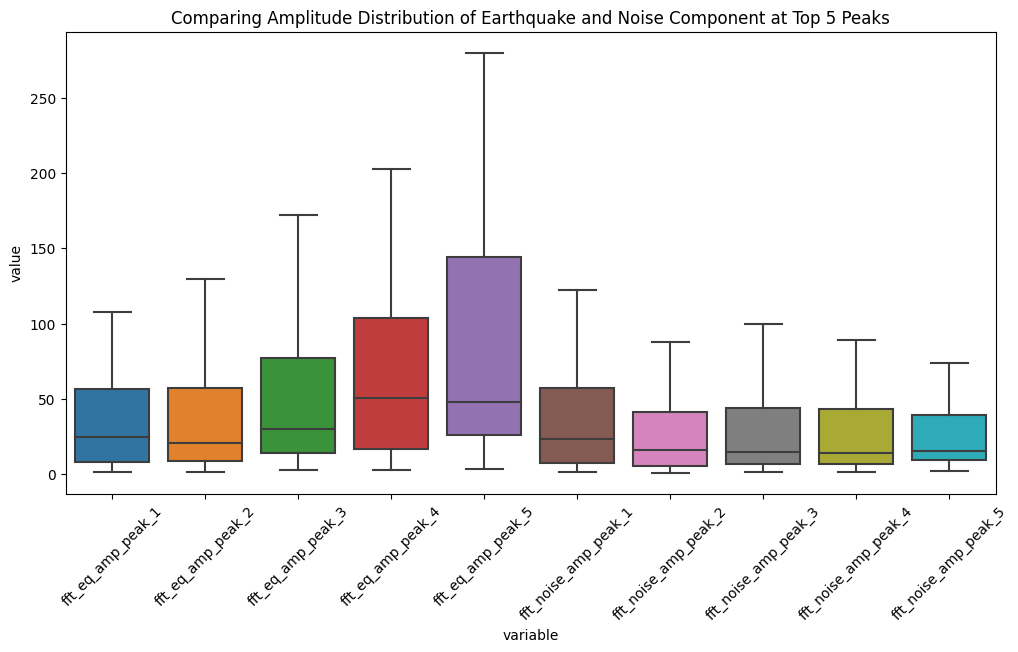

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(x="variable", y="value", showfliers=False,
            data=pd.melt(df_fft[["fft_eq_amp_peak_1","fft_eq_amp_peak_2","fft_eq_amp_peak_3","fft_eq_amp_peak_4","fft_eq_amp_peak_5",
                                "fft_noise_amp_peak_1","fft_noise_amp_peak_2","fft_noise_amp_peak_3","fft_noise_amp_peak_4","fft_noise_amp_peak_5"]]))


plt.xticks(rotation=45)
plt.title('Comparing Amplitude Distribution of Earthquake and Noise Component at Top 5 Peaks')
plt.show()

#### Power Spectral Density Analysis. Finding PSD of noise and earthquake component separately.
PSD informs us about the strength or power of the different frequency component. Like FFT, the peaks of the signal reamin at the same location only the width and height differs.

In [13]:
#Calculating the power spectral density of each signal

from scipy.signal import welch

npts = 16800                                        # number of samples in the trace
dt = 0.025                                          # sample interval

def get_psd_values(y_values, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

list_psd_eq = list()
list_psd_eq_labels = list()

list_psd_noise = list()
list_psd_noise_labels = list()

percentile=5
denominator = 10

list_psd_all = list()

for filename in list_of_signals:

  list_psd_eq_labels.append(filename)
  list_psd_noise_labels.append(filename)

  arr_signal = main_dataframe_vertical[main_dataframe_vertical["FileName"]==filename]["vertical"] # filter_df[filter_df["File"]==filename]["Signal"].iloc[0] #filter_df[filter_df["File"]==filename]["Signal"].iloc[0]

  arr_signal_eq = arr_signal[4800:16800]
  arr_signal_noise = arr_signal[0:4800]

  signal_min_eq = np.nanpercentile(arr_signal_eq, percentile)
  signal_max_eq = np.nanpercentile(arr_signal_eq, 100-percentile)
  mph_eq = signal_min_eq + (signal_max_eq - signal_min_eq)/denominator

  signal_min_noise = np.nanpercentile(arr_signal_noise, percentile)
  signal_max_noise = np.nanpercentile(arr_signal_noise, 100-percentile)
  mph_noise = signal_min_noise + (signal_max_noise - signal_min_noise)/denominator

  gf_eq_psd = get_features(*get_psd_values(arr_signal_eq, 40), mph_eq)
  gf_noise_psd = get_features(*get_psd_values(arr_signal_noise, 40), mph_noise)

  list_psd_eq.append(gf_eq_psd)
  list_psd_noise.append(gf_noise_psd)


  # list_flatten = list(itertools.chain.from_iterable([list(itertools.chain.from_iterable(gf_eq_psd)),list(itertools.chain.from_iterable(gf_noise_psd))]))
  list_flatten = list(itertools.chain.from_iterable(gf_eq_psd))+list(itertools.chain.from_iterable(gf_noise_psd))
  list_psd_all.append([filename]+list_flatten)

In [14]:
df_psd = \
pd.DataFrame(list_psd_all, columns=["file","psd_eq_freq_peak_1","psd_eq_freq_peak_2","psd_eq_freq_peak_3","psd_eq_freq_peak_4","psd_eq_freq_peak_5",
"psd_eq_amp_peak_1","psd_eq_amp_peak_2","psd_eq_amp_peak_3","psd_eq_amp_peak_4","psd_eq_amp_peak_5",
"psd_noise_freq_peak_1","psd_noise_freq_peak_2","psd_noise_freq_peak_3","psd_noise_freq_peak_4","psd_noise_freq_peak_5",
"psd_noise_amp_peak_1","psd_noise_amp_peak_2","psd_noise_amp_peak_3","psd_noise_amp_peak_4","psd_noise_amp_peak_5"])

df_psd.head()

,file,psd_eq_freq_peak_1,psd_eq_freq_peak_2,psd_eq_freq_peak_3,psd_eq_freq_peak_4,psd_eq_freq_peak_5,psd_eq_amp_peak_1,psd_eq_amp_peak_2,psd_eq_amp_peak_3,psd_eq_amp_peak_4,...,psd_noise_freq_peak_1,psd_noise_freq_peak_2,psd_noise_freq_peak_3,psd_noise_freq_peak_4,psd_noise_freq_peak_5,psd_noise_amp_peak_1,psd_noise_amp_peak_2,psd_noise_amp_peak_3,psd_noise_amp_peak_4,psd_noise_amp_peak_5
0,RTZSeis_NE68_Ev001,0.15625,0.93750,1.25000,2.03125,3.43750,2.598981e+05,3.240288e+04,3.238514e+04,4619.429357,...,0.15625,0.93750,2.03125,3.75000,4.21875,2.295957e+04,587.174629,4886.428508,28324.793477,17313.171821
1,RTZSeis_NE68_Ev004,0.15625,1.56250,2.81250,4.21875,5.00000,6.846686e+04,2.002338e+03,3.847061e+02,926.827940,...,0.31250,1.25000,2.81250,3.90625,5.31250,2.825343e+03,196.539845,1339.321511,50978.167885,1163.288789
2,RTZSeis_NE68_Ev002,0.15625,1.09375,1.71875,2.50000,3.28125,6.350601e+05,1.193428e+06,4.079642e+06,69563.922324,...,0.15625,1.40625,2.34375,3.28125,4.37500,4.828711e+04,2188.332500,1430.063691,2568.995944,10724.986265
3,RTZSeis_NE68_Ev003,0.15625,0.93750,1.40625,2.96875,4.53125,1.511972e+07,6.521958e+05,3.806239e+05,19669.367527,...,0.15625,1.09375,1.71875,3.12500,4.06250,2.477642e+07,3262.033895,33900.848242,403399.048339,26023.603731
4,RTZSeis_NE68_Ev006,0.15625,1.40625,2.50000,3.59375,4.84375,1.350975e+05,1.923141e+04,2.280360e+04,23274.893021,...,0.15625,2.50000,2.96875,3.75000,4.37500,2.589352e+03,112998.046552,77240.157997,63231.178513,9912.698357


In [15]:
temp=list()
for i in range(len(list_psd_eq)):
  temp.append(list_psd_eq[i][0])

psd_eq_fq_flatten = list(itertools.chain.from_iterable(temp))

temp=list()
for i in range(len(list_psd_eq)):
  temp.append(list_psd_eq[i][1])

psd_eq_amp_flatten = list(itertools.chain.from_iterable(temp))

temp=list()
for i in range(len(list_psd_noise)):
  temp.append(list_psd_noise[i][0])

psd_noise_fq_flatten = list(itertools.chain.from_iterable(temp))

temp=list()
for i in range(len(list_psd_noise)):
  temp.append(list_psd_noise[i][1])

psd_noise_amp_flatten = list(itertools.chain.from_iterable(temp))

#### Visualizng the overall PSD distribution for both noise and earthquakae component.

In [16]:
df_psd_temp = pd.DataFrame(list(zip(psd_eq_fq_flatten,psd_eq_amp_flatten,psd_noise_fq_flatten,psd_noise_amp_flatten))
                         ,columns=["psd_eq_fq","psd_eq_amp","psd_noise_fq","psd_noise_amp"])

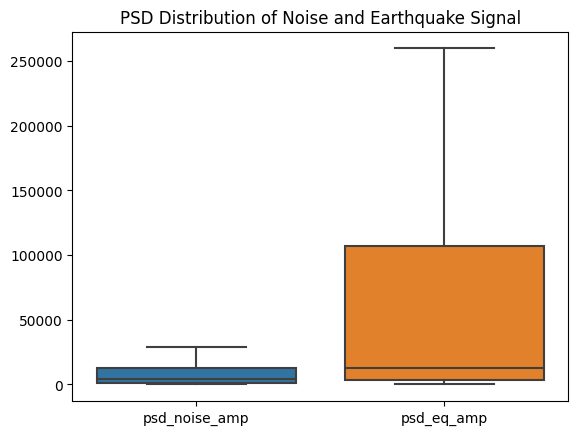

In [17]:
import seaborn as sns

sns.boxplot(data=df_psd_temp[["psd_noise_amp","psd_eq_amp"]],showfliers=False)
plt.title('PSD Distribution of Noise and Earthquake Signal')
plt.show()

#### Visualizing the PSD component distribution for each peak of noise and earthquake component.

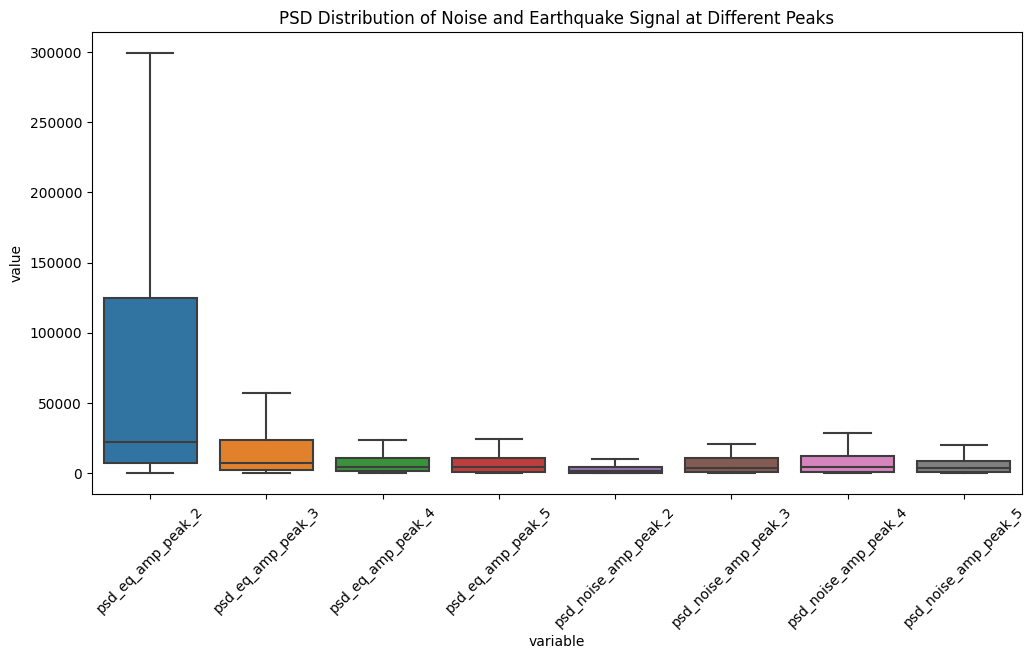

Keeping peak one out from the below graph as it is too high


In [18]:
plt.figure(figsize=(12,6))
sns.boxplot(x="variable", y="value", showfliers=False,
            data=pd.melt(df_psd[["psd_eq_amp_peak_2","psd_eq_amp_peak_3","psd_eq_amp_peak_4","psd_eq_amp_peak_5",
                                 "psd_noise_amp_peak_2","psd_noise_amp_peak_3","psd_noise_amp_peak_4","psd_noise_amp_peak_5"]]))


plt.xticks(rotation=45)
plt.title('PSD Distribution of Noise and Earthquake Signal at Different Peaks')
plt.show()
print("Keeping peak one out from the below graph as it is too high")

#### Starting to work for Clustering the signals based on the features dervied above. Preparing one big dataframe with all features together.

In [19]:
df_fft['filename']=df_fft['filename'].astype('string')
df_psd['file']=df_psd['file'].astype('string')

df_final = pd.concat([df_fft,df_psd], axis=1)
df_final = df_final.drop('file', axis=1)

df_final.head()

,filename,fft_eq_freq_peak_1,fft_eq_freq_peak_2,fft_eq_freq_peak_3,fft_eq_freq_peak_4,fft_eq_freq_peak_5,fft_eq_amp_peak_1,fft_eq_amp_peak_2,fft_eq_amp_peak_3,fft_eq_amp_peak_4,...,psd_noise_freq_peak_1,psd_noise_freq_peak_2,psd_noise_freq_peak_3,psd_noise_freq_peak_4,psd_noise_freq_peak_5,psd_noise_amp_peak_1,psd_noise_amp_peak_2,psd_noise_amp_peak_3,psd_noise_amp_peak_4,psd_noise_amp_peak_5
0,RTZSeis_NE68_Ev001,0.003334,0.013336,0.026671,0.033339,0.050008,4.401341,12.481596,30.855069,70.456164,...,0.15625,0.93750,2.03125,3.75000,4.21875,2.295957e+04,587.174629,4886.428508,28324.793477,17313.171821
1,RTZSeis_NE68_Ev004,0.003334,0.013336,0.026671,0.040007,0.046674,8.758614,15.240614,13.066826,9.226154,...,0.31250,1.25000,2.81250,3.90625,5.31250,2.825343e+03,196.539845,1339.321511,50978.167885,1163.288789
2,RTZSeis_NE68_Ev002,0.003334,0.010002,0.020003,0.026671,0.033339,25.898024,58.175121,77.080755,76.841749,...,0.15625,1.40625,2.34375,3.28125,4.37500,4.828711e+04,2188.332500,1430.063691,2568.995944,10724.986265
3,RTZSeis_NE68_Ev003,0.003334,0.013336,0.023337,0.030005,0.036673,211.433854,564.959712,817.466019,831.666906,...,0.15625,1.09375,1.71875,3.12500,4.06250,2.477642e+07,3262.033895,33900.848242,403399.048339,26023.603731
4,RTZSeis_NE68_Ev006,0.003334,0.010002,0.016669,0.026671,0.036673,17.821656,21.037807,29.579504,23.586126,...,0.15625,2.50000,2.96875,3.75000,4.37500,2.589352e+03,112998.046552,77240.157997,63231.178513,9912.698357


#### Trying to see the correlation among all the features. As we can see that majority of the features are not highly correlated thus good to be fed to a machine learning algorithm.

<ipython-input-25-96ce371244e7>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_final.corr()


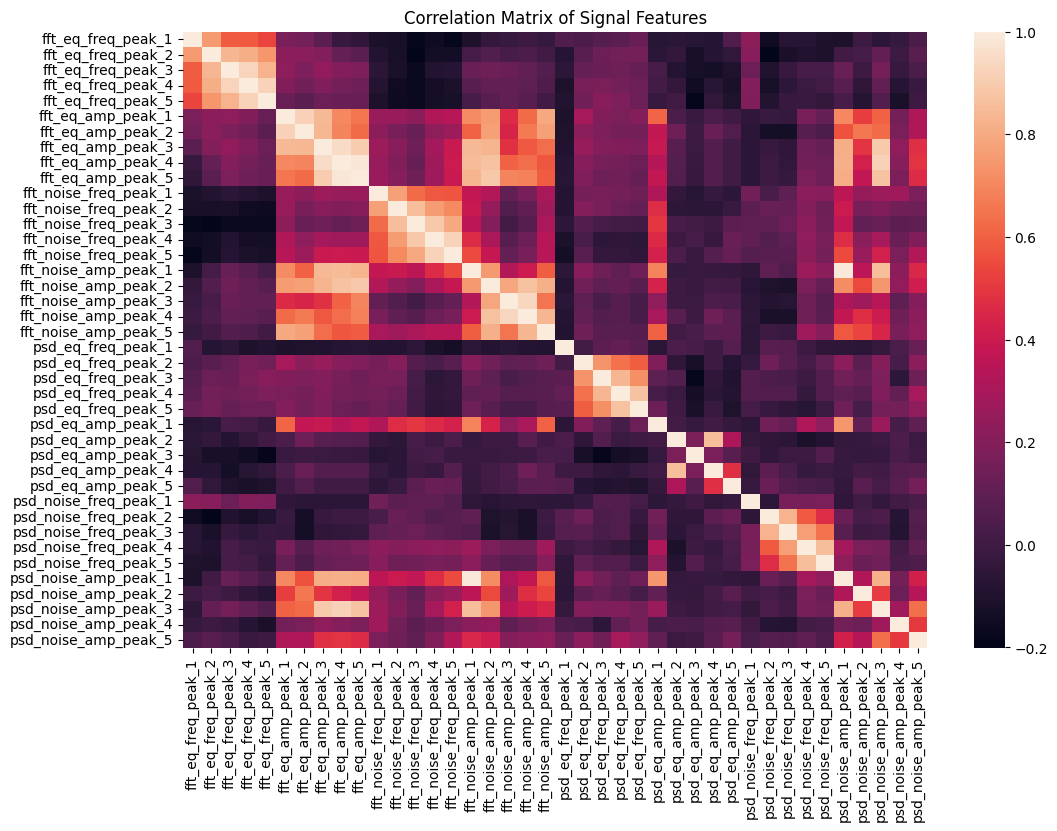

In [25]:
plt.figure(figsize=(12,8))
corr_matrix = df_final.corr()
sns.heatmap(corr_matrix)
plt.title('Correlation Matrix of Signal Features')
plt.show()

#### Importing all necessary libariries for ML.

In [28]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,ShuffleSplit,GridSearchCV
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs,make_moons
from yellowbrick.cluster import KElbowVisualizer
import time
from matplotlib.colors import ListedColormap


In [29]:
df_dummies = pd.get_dummies(df_final[df_final.columns[1:]])

df_dummies.head()

,fft_eq_freq_peak_1,fft_eq_freq_peak_2,fft_eq_freq_peak_3,fft_eq_freq_peak_4,fft_eq_freq_peak_5,fft_eq_amp_peak_1,fft_eq_amp_peak_2,fft_eq_amp_peak_3,fft_eq_amp_peak_4,fft_eq_amp_peak_5,...,psd_noise_freq_peak_1,psd_noise_freq_peak_2,psd_noise_freq_peak_3,psd_noise_freq_peak_4,psd_noise_freq_peak_5,psd_noise_amp_peak_1,psd_noise_amp_peak_2,psd_noise_amp_peak_3,psd_noise_amp_peak_4,psd_noise_amp_peak_5
0,0.003334,0.013336,0.026671,0.033339,0.050008,4.401341,12.481596,30.855069,70.456164,60.750847,...,0.15625,0.93750,2.03125,3.75000,4.21875,2.295957e+04,587.174629,4886.428508,28324.793477,17313.171821
1,0.003334,0.013336,0.026671,0.040007,0.046674,8.758614,15.240614,13.066826,9.226154,17.511937,...,0.31250,1.25000,2.81250,3.90625,5.31250,2.825343e+03,196.539845,1339.321511,50978.167885,1163.288789
2,0.003334,0.010002,0.020003,0.026671,0.033339,25.898024,58.175121,77.080755,76.841749,99.230623,...,0.15625,1.40625,2.34375,3.28125,4.37500,4.828711e+04,2188.332500,1430.063691,2568.995944,10724.986265
3,0.003334,0.013336,0.023337,0.030005,0.036673,211.433854,564.959712,817.466019,831.666906,511.564590,...,0.15625,1.09375,1.71875,3.12500,4.06250,2.477642e+07,3262.033895,33900.848242,403399.048339,26023.603731
4,0.003334,0.010002,0.016669,0.026671,0.036673,17.821656,21.037807,29.579504,23.586126,33.064763,...,0.15625,2.50000,2.96875,3.75000,4.37500,2.589352e+03,112998.046552,77240.157997,63231.178513,9912.698357


#### Normalizing all the features using Standard Scaler.

In [30]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_dummies)

#### Performing Elbow Method to see the optimal number of clusters. Choosing 4 as the graph indiates in the trough.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

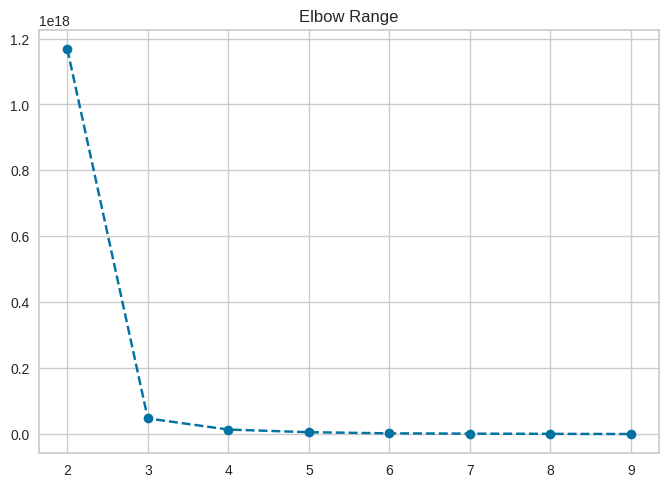

In [31]:
ssd = []

for k in range(2,10):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df_dummies)

    ssd.append(model.inertia_)

plt.plot(range(2,10),ssd,"o--")
plt.title("Elbow Range")
plt.show()

#### Performing K-Means Clustering and Visualizing which which features are most influential for cluster generation.

In [33]:
k_means_model = KMeans(n_clusters=4, random_state=42)
k_means_model.fit(df_scaled)
cluster_labels = k_means_model.predict(df_scaled)
df_dummies["Cluster"] = cluster_labels
df_dummies["filename"] = df_final["filename"]
df_dummies.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,fft_eq_freq_peak_1,fft_eq_freq_peak_2,fft_eq_freq_peak_3,fft_eq_freq_peak_4,fft_eq_freq_peak_5,fft_eq_amp_peak_1,fft_eq_amp_peak_2,fft_eq_amp_peak_3,fft_eq_amp_peak_4,fft_eq_amp_peak_5,...,psd_noise_freq_peak_3,psd_noise_freq_peak_4,psd_noise_freq_peak_5,psd_noise_amp_peak_1,psd_noise_amp_peak_2,psd_noise_amp_peak_3,psd_noise_amp_peak_4,psd_noise_amp_peak_5,Cluster,filename
0,0.003334,0.013336,0.026671,0.033339,0.050008,4.401341,12.481596,30.855069,70.456164,60.750847,...,2.03125,3.75000,4.21875,2.295957e+04,587.174629,4886.428508,28324.793477,17313.171821,3,RTZSeis_NE68_Ev001
1,0.003334,0.013336,0.026671,0.040007,0.046674,8.758614,15.240614,13.066826,9.226154,17.511937,...,2.81250,3.90625,5.31250,2.825343e+03,196.539845,1339.321511,50978.167885,1163.288789,3,RTZSeis_NE68_Ev004
2,0.003334,0.010002,0.020003,0.026671,0.033339,25.898024,58.175121,77.080755,76.841749,99.230623,...,2.34375,3.28125,4.37500,4.828711e+04,2188.332500,1430.063691,2568.995944,10724.986265,3,RTZSeis_NE68_Ev002
3,0.003334,0.013336,0.023337,0.030005,0.036673,211.433854,564.959712,817.466019,831.666906,511.564590,...,1.71875,3.12500,4.06250,2.477642e+07,3262.033895,33900.848242,403399.048339,26023.603731,3,RTZSeis_NE68_Ev003
4,0.003334,0.010002,0.016669,0.026671,0.036673,17.821656,21.037807,29.579504,23.586126,33.064763,...,2.96875,3.75000,4.37500,2.589352e+03,112998.046552,77240.157997,63231.178513,9912.698357,3,RTZSeis_NE68_Ev006


<ipython-input-37-32b18f824caf>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_dummies.corr()["Cluster"].iloc[:-1].sort_values().plot(kind="bar")


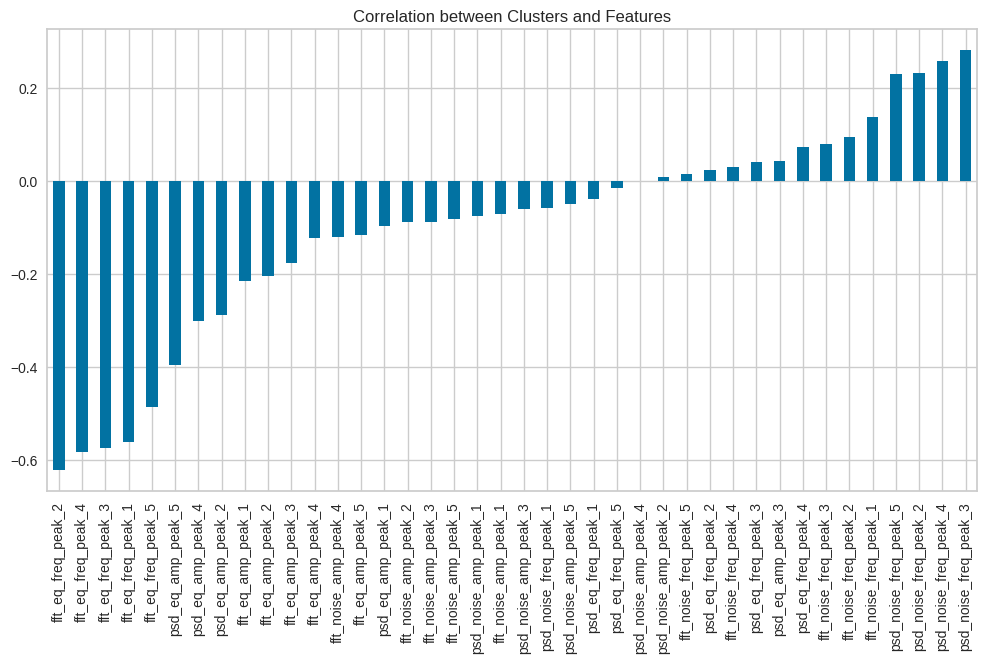

In [37]:
plt.figure(figsize=(12,6))
df_dummies.corr()["Cluster"].iloc[:-1].sort_values().plot(kind="bar")
plt.title("Correlation between Clusters and Features")
plt.show()

#### Count of Signals in each Cluster.

In [39]:
df_dummies["Cluster"].value_counts()


3    74
1    19
2     4
0     3
Name: Cluster, dtype: int64

In [ ]:
#df_dummies.head()

#### Visualising the signals of each cluster. Picking Randomly two signals from each cluster for the visualization.

Text(0.5, 1.0, 'Visual Inspection of Clustered Signal')

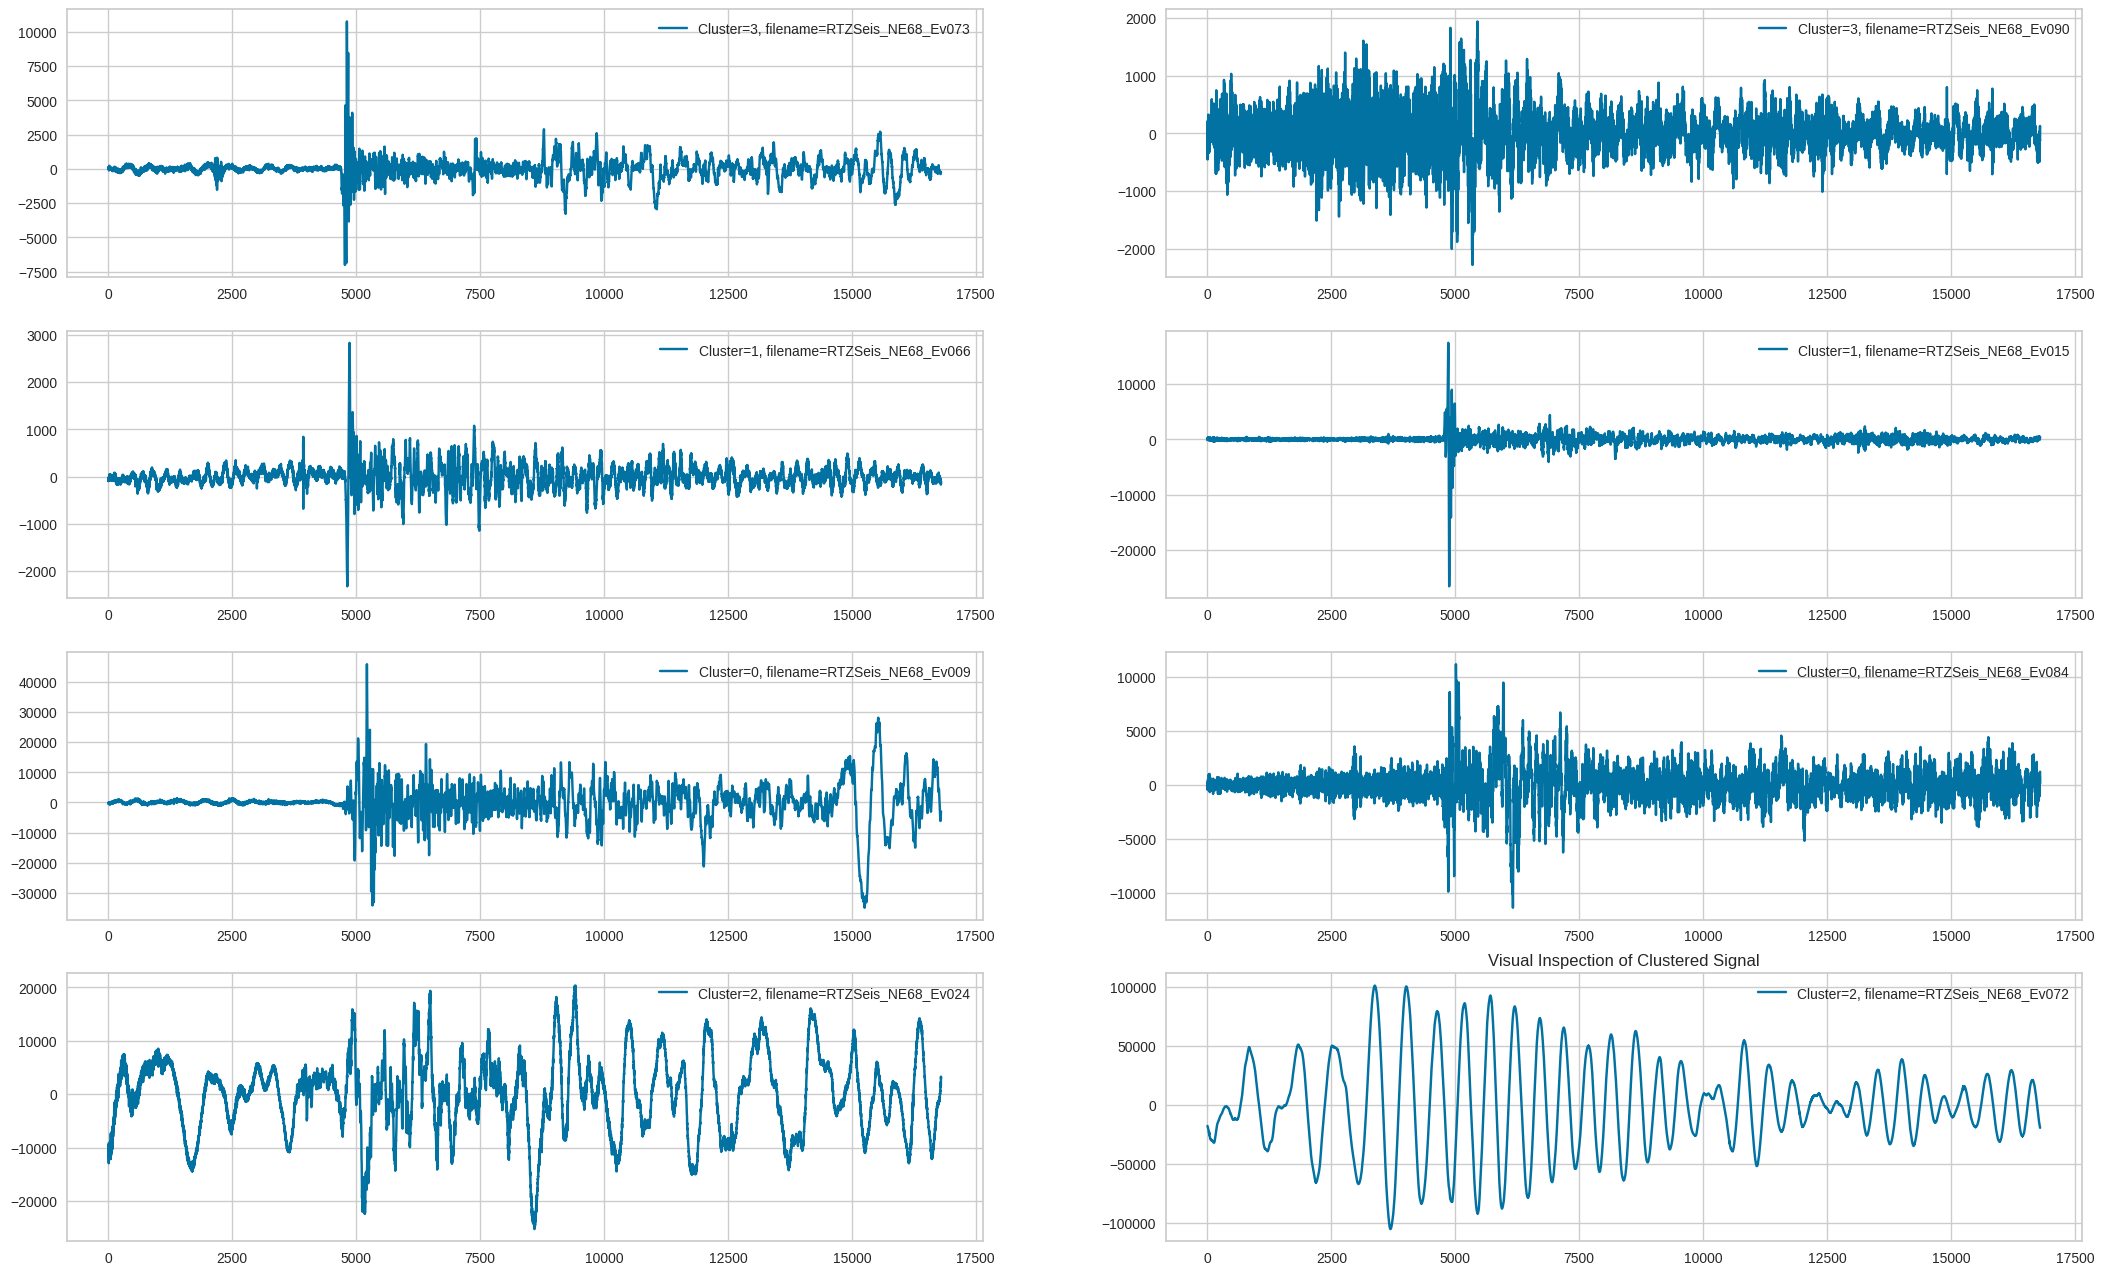

In [44]:
#Visualize the signals in each cluster
import matplotlib.pyplot as plt
kmeans_cluster_list = df_dummies[['filename','Cluster']]
mapping = dict(kmeans_cluster_list[['filename', 'Cluster']].values)
main_dataframe_cluster = main_dataframe.copy()
main_dataframe_cluster["cluster"] = main_dataframe_cluster["FileName"].map(mapping)

rowcount=0
temp = main_dataframe_cluster["cluster"].unique()
f, axises = plt.subplots(len(temp), 2, figsize=(26,16)) #sharey=True

for i in temp:
  df_cluster_temp = main_dataframe_cluster[main_dataframe_cluster["cluster"]==i]
  for j in range(0,2):
    fname = np.random.choice(df_cluster_temp.FileName)
    sig = df_cluster_temp[df_cluster_temp["FileName"]==fname]['vertical']

    axises[rowcount,j].plot(sig, label = "Cluster="+i.astype('str')+", filename="+fname)
    axises[rowcount,j].legend()
  rowcount+=1

plt.title('Visual Inspection of Clustered Signal')

#### Visualzing frequency profile of signals at different clusters
As it can be seen majority of the signals in our dataset has been assiged cluster 3 and their frequency profile shows that the frequency values in custer three is more than cluster 2. Also in cluster 2 the distrbution of frequencies in noise are much wider than cluster three. This informs us that cluster three needs to be further analyzed to understand signal characteristics.

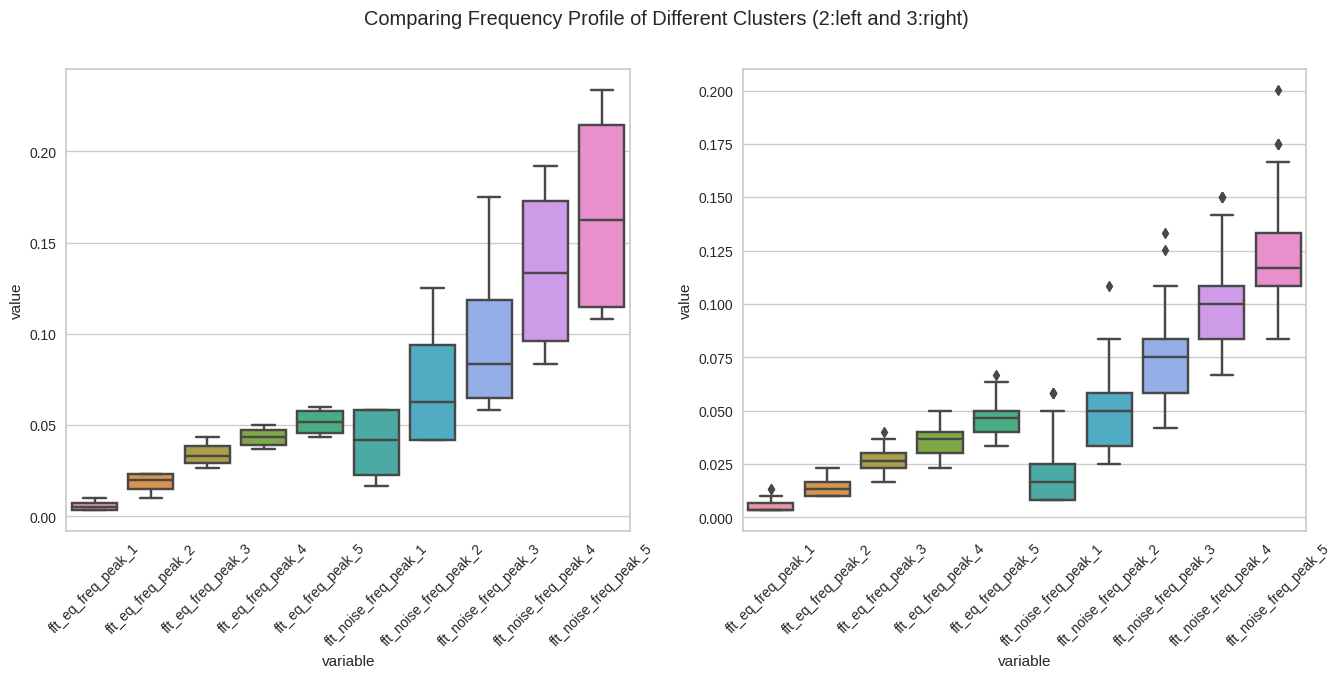

In [76]:
#plot of fft noise vs eq frequency
#plt.figure(figsize=(12,6))
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(16,6))
sns.boxplot(x="variable", y="value", ax=ax[0],
            data=pd.melt(df_dummies.query('Cluster==2')[["fft_eq_freq_peak_1","fft_eq_freq_peak_2","fft_eq_freq_peak_3","fft_eq_freq_peak_4","fft_eq_freq_peak_5",
                                 "fft_noise_freq_peak_1","fft_noise_freq_peak_2","fft_noise_freq_peak_3","fft_noise_freq_peak_4","fft_noise_freq_peak_5"]]))

sns.boxplot(x="variable", y="value", ax=ax[1],
            data=pd.melt(df_dummies.query('Cluster==3')[["fft_eq_freq_peak_1","fft_eq_freq_peak_2","fft_eq_freq_peak_3","fft_eq_freq_peak_4","fft_eq_freq_peak_5",
                                 "fft_noise_freq_peak_1","fft_noise_freq_peak_2","fft_noise_freq_peak_3","fft_noise_freq_peak_4","fft_noise_freq_peak_5"]]))

ax[0].tick_params(axis='x', labelrotation = 45)
ax[1].tick_params(axis='x', labelrotation = 45)
fig.suptitle('Comparing Frequency Profile of Different Clusters (2:left and 3:right)')
fig.show()

#### Next we calculate Spectogram of each signal to use a neural network  better understand different clusters.First, passing a bandpas filter through each and every signal. Refering the previously determined FFT graph which shows us the frequncy distribution of noise and earthquake component. Choosing frequncy as per that graph.

In [81]:
npts = 16800                                        # number of samples in the trace
dt = 0.025                                          # sample interval

from obspy import Trace

filtered_signals = list()
for filename in list_of_signals:
  arr_signal = main_dataframe_vertical[main_dataframe_vertical["FileName"]==filename]["vertical"]
  stLP=arr_signal.copy()
  stLPTR = Trace(data=np.array(stLP))
  stLPTR.filter(type="bandpass", freqmin=0.015/(1. / (2. * dt)), freqmax=0.05/(1. / (2. * dt)), corners=4, zerophase=True)
  filtered_signals.append([filename,stLPTR.data])

#filtered_signals

In [82]:
temp=list()
for i in range(len(filtered_signals)):
  temp.append(filtered_signals[i][0])

filter_eq_fname_flatten = temp

temp=list()
for i in range(len(filtered_signals)):
  temp.append(filtered_signals[i][1])

filter_eq_flatten = temp

filter_df = pd.DataFrame(list(zip(filter_eq_fname_flatten,filter_eq_flatten)), columns=["File","Signal"])
filter_df.head()

,File,Signal
0,RTZSeis_NE68_Ev001,"[-25.73124152254439, -25.749928089225648, -25...."
1,RTZSeis_NE68_Ev004,"[17.853388187038142, 17.865080378254362, 17.87..."
2,RTZSeis_NE68_Ev002,"[-40.185045211726745, -40.46078764908218, -40...."
3,RTZSeis_NE68_Ev003,"[-340.2774941368039, -313.4652249202529, -286...."
4,RTZSeis_NE68_Ev006,"[1.1336027642923014, 1.143900403072891, 1.1539..."


#### Generating Spectogram.
#### Note, 16800/(128-30) = 171. Thus 171 is the resultion that we get in the entire time length. Which is around 4.25 seconds of window.
#### As the earthquake is occuring after 120 seconds therefore we get separate windows in the region of 120th second. 4.25*28 = 119 second. So from 120th second.
#### We are moving into the next window where we are supposed to get some singal.
#### So our spectogram size is 129.

In [85]:
import scipy.signal as signal

#np.random.randint(0,100,5)

In [86]:
list_spectogram = list()
list_spectogram_flatten = list()

for i in range(0,len(filter_df)):
  signal_temp = filter_df.iloc[i]["Signal"]
  file_temp = filter_df.iloc[i]["File"]
  a_f, a_t, Sxx = signal.spectrogram(signal_temp, 40, scaling='spectrum', nperseg=128, nfft = 256, noverlap=30)
  sxx_updated = np.log10(Sxx)
  a_f_logsclaed = np.log10(a_f)
  a_f_logsclaed[0] = 0
  sxx_updated.reshape(Sxx.shape)

  list_spectogram_flatten.append([file_temp]+list(sxx_updated.flatten()))

  list_spectogram.append([file_temp,a_f,a_t,signal_temp,sxx_updated,a_f_logsclaed])

#list_spectogram

<ipython-input-86-6127dd2212ce>:9: RuntimeWarning: divide by zero encountered in log10
  a_f_logsclaed = np.log10(a_f)


#### Randomly picking up 5 signals and visualizing their the filtered signal with corrosponding Spectograms.

<ipython-input-90-b6a571b3237d>:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  axises[rowcount,0].pcolormesh(at, a_f_logsclaed, spec, shading = 'nearest', cmap = plt.cm.RdYlGn_r)


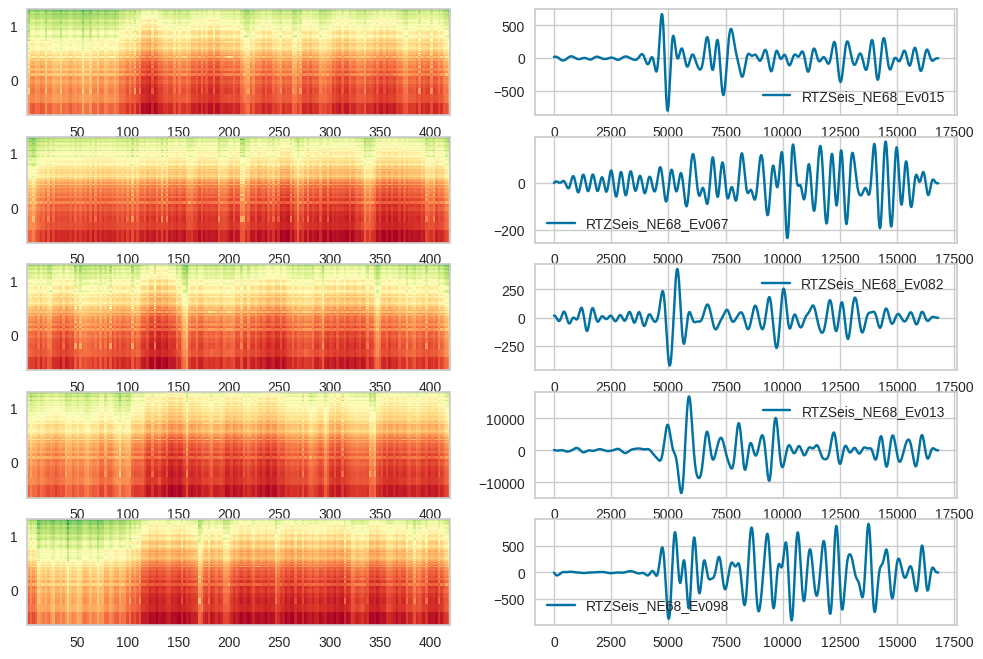

In [90]:
f, axises = plt.subplots(5, 2, figsize=(12,8))
rowcount=0
for i in np.random.randint(0,100,5):
  filename= list_spectogram[i][0]
  af = list_spectogram[i][1]
  at = list_spectogram[i][2]
  sig = list_spectogram[i][3]
  spec = list_spectogram[i][4]

  axises[rowcount,0].pcolormesh(at, a_f_logsclaed, spec, shading = 'nearest', cmap = plt.cm.RdYlGn_r)

  axises[rowcount,1].plot(sig, label = filename)
  axises[rowcount,1].legend()

  rowcount+=1

#### Deep Embedded Clustering Analysis

##### DEC Models

#### Refering the paper of Junyuan Xie, Ross Girshick & Ali Farhadi. Also referring the blogs of Dlology and Analyticsvidhya for usupervised deep learning with keras.

In [ ]:
import os
import keras
from sklearn import metrics
import numpy as np
import pandas as pd
import keras.backend as K

from time import time

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from tensorflow.keras.layers import Layer, InputSpec

from matplotlib.pyplot import imread
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score


In [ ]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
"""
Keras implementation for Deep Embedded Clustering (DEC) algorithm:

Original Author:
    Xifeng Guo. 2017.1.30
"""


def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')

##### DEC Execution
##### After trying various combinations, choosing 9 to be a better cluster for this method.

In [ ]:
ip_temp = np.array(list_spectogram_flatten)
ip = ip_temp[:,1:]
ip = ip.astype(float)
n_clusters = 9

##### Standardizing the spectogram data.

In [ ]:
for i in range(len(ip)):
    ip[i] = (ip[i] - ip[i].mean())/ip[i].std()

In [ ]:
dims = [22059, 50, 50, 100, 9]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform', seed=0)
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 500
batch_size = 10
save_dir = './sample_data'


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


##### Calling the instance of auto encoder model and Pretraining that model. It will do diemensionality reduction of the input spectogram to 9 features and then again reconstructing the original singal from this 9 features. The loss while reconstruction will be used to train the encoder model to optimize.

In [ ]:
autoencoder, encoder = autoencoder(dims, init=init)

In [ ]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

In [ ]:
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png')

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(ip,ip, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)

#loss reduced upto 0.04 from 1

In [ ]:
#autoencoder.save_weights(save_dir + '/ae_weights.h5')
#autoencoder.load_weights(save_dir + '/ae_weights.h5')

##### Building the custom output layer of the autoencoder which tries to find out the probability of each sample belonging to a particular cluster.  This probability is calculated using Student-T distrbution. This layer has a shape of 100x9 where 100 is the number of samples and 9 clusters. Each point i_j can be interpreted as the probability of assinging a sample to cluster j. The q parameter in this code holds that probability. The index of the max probability with argmax gives the intially determined clutser of a sample.

In [ ]:
clustering_layer = ClusteringLayer(n_clusters=9, name='clusters')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [ ]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld') #SGD(0.01, 0.9)


##### The custom clutering layer's output is then initialized with the weights K-Means clustering algorithm determines.


In [ ]:
kmeans = KMeans(n_clusters=9, n_init=20, random_state=265)

In [ ]:
y_pred = kmeans.fit_predict(encoder.predict(ip))
#y_pred

4/4 [==============================] - 0s 5ms/step


In [ ]:
y_pred_last = np.copy(y_pred)

model.get_layer(name='clusters').set_weights([kmeans.cluster_centers_])


##### Now it is required to make better clustering assignment. This is done with an auxiliary target distribution calcuated based on present cluster assignment. First a auxilary distrbution is calculated which is being called as centroid-based target probability distribution. Then the KL divergence loss is calculated between this target distribution and the current assigned distrbution from the previous steps. The model is then trained to minimize this KL loss.

This process gradually improves the clustering as well as the feature representation.

In [ ]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [ ]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(ip.shape[0])
tol = 0.001 # tolerance threshold to stop training

In [ ]:
#model.predict(ip, verbose=0)
#model.predict(ip, verbose=0).shape
#(model.predict(ip, verbose=0)).argmax(1)
#target_distribution(model.predict(ip, verbose=0))

In [ ]:
loss_curve=list()
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(ip, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, ip.shape[0])]
    loss = model.train_on_batch(x=ip[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= ip.shape[0] else 0
    loss_curve.append(loss)

model.save_weights(save_dir + '/DEC_model_final.h5')

delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


In [ ]:
q = model.predict(ip, verbose=0)
p = target_distribution(q)
y_pred = q.argmax(1)

##### Creating a dataframe with the signals and the assigned clusters of each signal provided by the DEC algorithm.

In [ ]:
list_new_clusters=list()

for i in range(len(y_pred)):
  filename= list_spectogram[i][0]
  af = list_spectogram[i][1]
  at = list_spectogram[i][2]
  sig = list_spectogram[i][3]
  spec = list_spectogram[i][4]
  clus = y_pred[i]

  list_new_clusters.append([filename,af,at,sig,spec,clus])


In [ ]:
df_dec_cluster = pd.DataFrame(list_new_clusters, columns = ["Filename","Time","Frequency","Signal_Filtered","Spectogram","Cluster"])

In [ ]:
#number of signals belonging to each cluster
df_dec_cluster["Cluster"].value_counts()

5    18
6    16
3    14
8    13
1    13
4     8
7     6
0     6
2     6
Name: Cluster, dtype: int64

##### Visualizing signals belonging to each cluster. The below code randomly pick a signal that belong to each cluster and plot the time series graph.

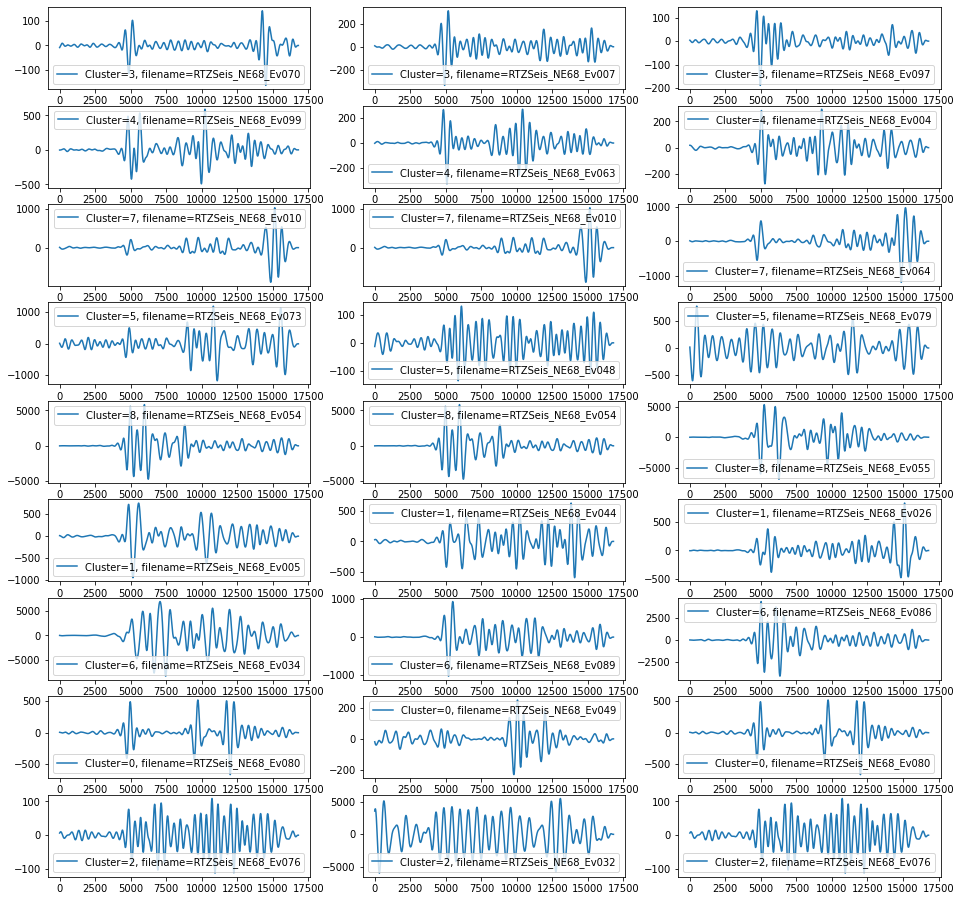

In [ ]:
temp = df_dec_cluster["Cluster"].unique()
f, axises = plt.subplots(len(temp), 3, figsize=(16,16))
rowcount=0

for i in temp:
  df_cluster_temp = df_dec_cluster[df_dec_cluster["Cluster"]==i]
  for j in range(0,3):
    idx = np.random.choice(df_cluster_temp.index)

    filename= df_cluster_temp.loc[idx,"Filename"]
    af = df_cluster_temp.loc[idx,"Frequency"]
    at = df_cluster_temp.loc[idx,"Time"]
    sig = df_cluster_temp.loc[idx,"Signal_Filtered"]
    spec = df_cluster_temp.loc[idx,"Spectogram"]

    axises[rowcount,j].plot(sig, label = "Cluster="+i.astype('str')+", filename="+filename)
    axises[rowcount,j].legend()

  rowcount+=1

